In [1]:
#importing neccessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import *


In [2]:
#reading the dataset
data=pd.read_csv('Keylogger_Detection.csv')
data.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [3]:
#droping the 'Unnamed: 0' column and checking the data types of columns
data.drop(['Unnamed: 0'],inplace=True,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523617 entries, 0 to 523616
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       523610 non-null  object 
 1    Source IP                    523617 non-null  object 
 2    Source Port                  523617 non-null  float64
 3    Destination IP               523617 non-null  object 
 4    Destination Port             523617 non-null  float64
 5    Protocol                     523617 non-null  float64
 6    Timestamp                    523617 non-null  object 
 7    Flow Duration                523617 non-null  float64
 8    Total Fwd Packets            523617 non-null  float64
 9    Total Backward Packets       523617 non-null  float64
 10  Total Length of Fwd Packets   523617 non-null  float64
 11   Total Length of Bwd Packets  523617 non-null  float64
 12   Fwd Packet Length Max        523617 non-nul

In [4]:
data.shape #the no of records in the dataset

(523617, 85)

In [5]:
#checking for null values
pd.set_option('display.max_rows', None) #needed as the output was truncated before
print(data.isna().sum())

Flow ID                          7
 Source IP                       0
 Source Port                     0
 Destination IP                  0
 Destination Port                0
 Protocol                        0
 Timestamp                       0
 Flow Duration                   0
 Total Fwd Packets               0
 Total Backward Packets          0
Total Length of Fwd Packets      0
 Total Length of Bwd Packets     0
 Fwd Packet Length Max           0
 Fwd Packet Length Min           0
 Fwd Packet Length Mean          0
 Fwd Packet Length Std           0
Bwd Packet Length Max            0
 Bwd Packet Length Min           0
 Bwd Packet Length Mean          0
 Bwd Packet Length Std           0
Flow Bytes/s                     0
 Flow Packets/s                  0
 Flow IAT Mean                   3
 Flow IAT Std                    3
 Flow IAT Max                    3
 Flow IAT Min                    3
Fwd IAT Total                    3
 Fwd IAT Mean                    3
 Fwd IAT Std        

In [6]:
#droping the null values as the number of missing values is insignificant (22 null values for dataset with 5000000 values)
data.dropna(inplace=True)

#droping columns with same values for all records
for i in data.columns.tolist():
    if len(data[i].unique())<2:
        data.drop([i],axis=1,inplace=True)

data.drop([' CWE Flag Count'],axis=1,inplace=True) #does not have unique data (but different data type 0,0.0,"0.0")

<Axes: xlabel='Class', ylabel='count'>

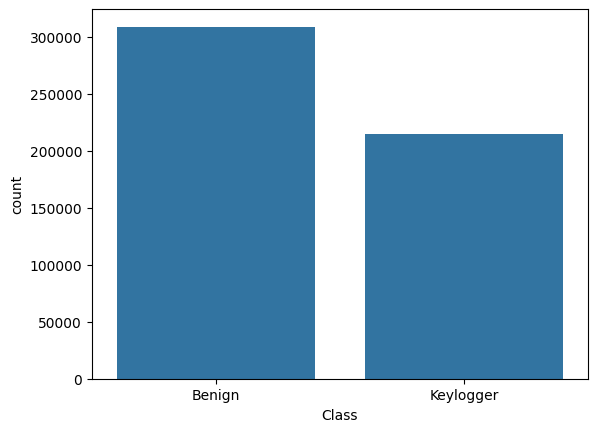

In [7]:
#checking for imbalance in data 
sns.countplot(data,x=data.Class)

In [8]:
data.shape #checking after droping unneccessary columns

(523593, 73)

In [9]:
data.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,6.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,203.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [10]:
#checking if the data is free of missing values
data.isna().sum()

Flow ID                         0
 Source IP                      0
 Source Port                    0
 Destination IP                 0
 Destination Port               0
 Protocol                       0
 Timestamp                      0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max  

In [11]:
#now data is usable
#encoding target column to 0 if not keylogger ,1 if it is keylogger
data['Class']=data['Class'].map({'Benign':0,'Keylogger':1})


In [12]:
data[' Timestamp'].head() #handling date and time as separtate columns

0    04/08/2017 05:12:36
1    04/08/2017 07:55:51
2    04/08/2017 08:48:19
3    04/08/2017 05:54:10
4    04/08/2017 08:44:25
Name:  Timestamp, dtype: object

In [13]:
# the date is of the format day/month/year , but default month/day/year
data[' Timestamp'] = pd.to_datetime(data[' Timestamp'], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
# Creating separate 'Date' and 'Time' columns
data['Date'] = data[' Timestamp'].dt.date
data['Time'] = data[' Timestamp'].dt.time



In [14]:
# Insert 'Date' column next to 'Timestamp'
data.insert(loc=data.columns.get_loc(' Timestamp') + 1, column='Date', value=data.pop('Date'))

# Insert 'Time' column next to 'Date'
data.insert(loc=data.columns.get_loc('Date') + 1, column='Time', value=data.pop('Time'))




In [15]:
data.drop(['Flow ID',' Timestamp'],axis=1,inplace=True) #now we don't need them as their data is now captured in separate columns 

In [16]:
data.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Date,Time,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,2017-08-04,05:12:36,12140931.0,9.0,6.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,2017-08-04,07:55:51,418882.0,102.0,203.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,2017-08-04,08:48:19,45.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,2017-08-04,05:54:10,541699.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,2017-08-04,08:44:25,7310795.0,3.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
#d1=data.select_dtypes(include=['object'])
#d1.head()

,Source IP,Destination IP,Date,Time,Packet Length Std
0,10.42.0.211,52.6.25.230,2017-08-04,05:12:36,501.347368
1,10.42.0.151,172.217.3.99,2017-08-04,07:55:51,676.644087
2,172.217.3.98,10.42.0.151,2017-08-04,08:48:19,31.754265
3,10.42.0.211,10.42.0.1,2017-08-04,05:54:10,107.38715
4,10.42.0.211,123.129.244.226,2017-08-04,08:44:25,0.0


In [18]:
#data[' CWE Flag Count'].unique()

In [19]:
#data.drop([' CWE Flag Count'],axis=1,inplace=True)

In [20]:
#for i in data.columns.tolist():
#    print(i," : ",data[i].unique())
#    print("\n")

 Source IP  :  ['10.42.0.211' '10.42.0.151' '172.217.3.98' ... '192.35.249.127'
 '31.13.67.36' '52.197.50.251']


 Source Port  :  [34451. 53892.   443. ... 22942. 47646.  1593.]


 Destination IP  :  ['52.6.25.230' '172.217.3.99' '10.42.0.151' ... '177.191.14.30'
 '199.16.156.9' '31.0.192.68']


 Destination Port  :  [4.4300e+02 5.0750e+04 5.3000e+01 ... 3.5978e+04 5.9410e+04 4.1728e+04]


 Protocol  :  [ 6. 17.  0.]


Date  :  [datetime.date(2017, 8, 4) datetime.date(2017, 7, 4)
 datetime.date(2017, 7, 17) datetime.date(2017, 7, 12)
 datetime.date(2017, 8, 5) datetime.date(2017, 7, 11)
 datetime.date(2017, 6, 30) datetime.date(2017, 6, 23)
 datetime.date(2017, 8, 14) datetime.date(2017, 7, 14)
 datetime.date(2017, 8, 15) datetime.date(2017, 6, 26)
 datetime.date(2017, 7, 5) datetime.date(2017, 8, 6)]


Time  :  [datetime.time(5, 12, 36) datetime.time(7, 55, 51)
 datetime.time(8, 48, 19) ... datetime.time(3, 27, 55)
 datetime.time(1, 10, 49) datetime.time(11, 39, 45)]


 Flow Duration

In [21]:
#preparing the encode 'object' datatypes
data[' Packet Length Std'] = pd.to_numeric(data[' Packet Length Std'], errors='coerce') #converting the data to numeric 

In [22]:
#for i in data.columns.tolist():
#    print(i," : ",i)


for i in  d1.columns.tolist():
    
    s1=LabelEncoder()
    data[i]=s1.fit_transform(data[i])

In [23]:
#under sampling as the dataset contains over 500000 values

X=data.iloc[:,:-1]
y=data.iloc[:,-1]

sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

In [ ]:
print(X_resampled.shape)
print(y_resampled.shape)

<Axes: >

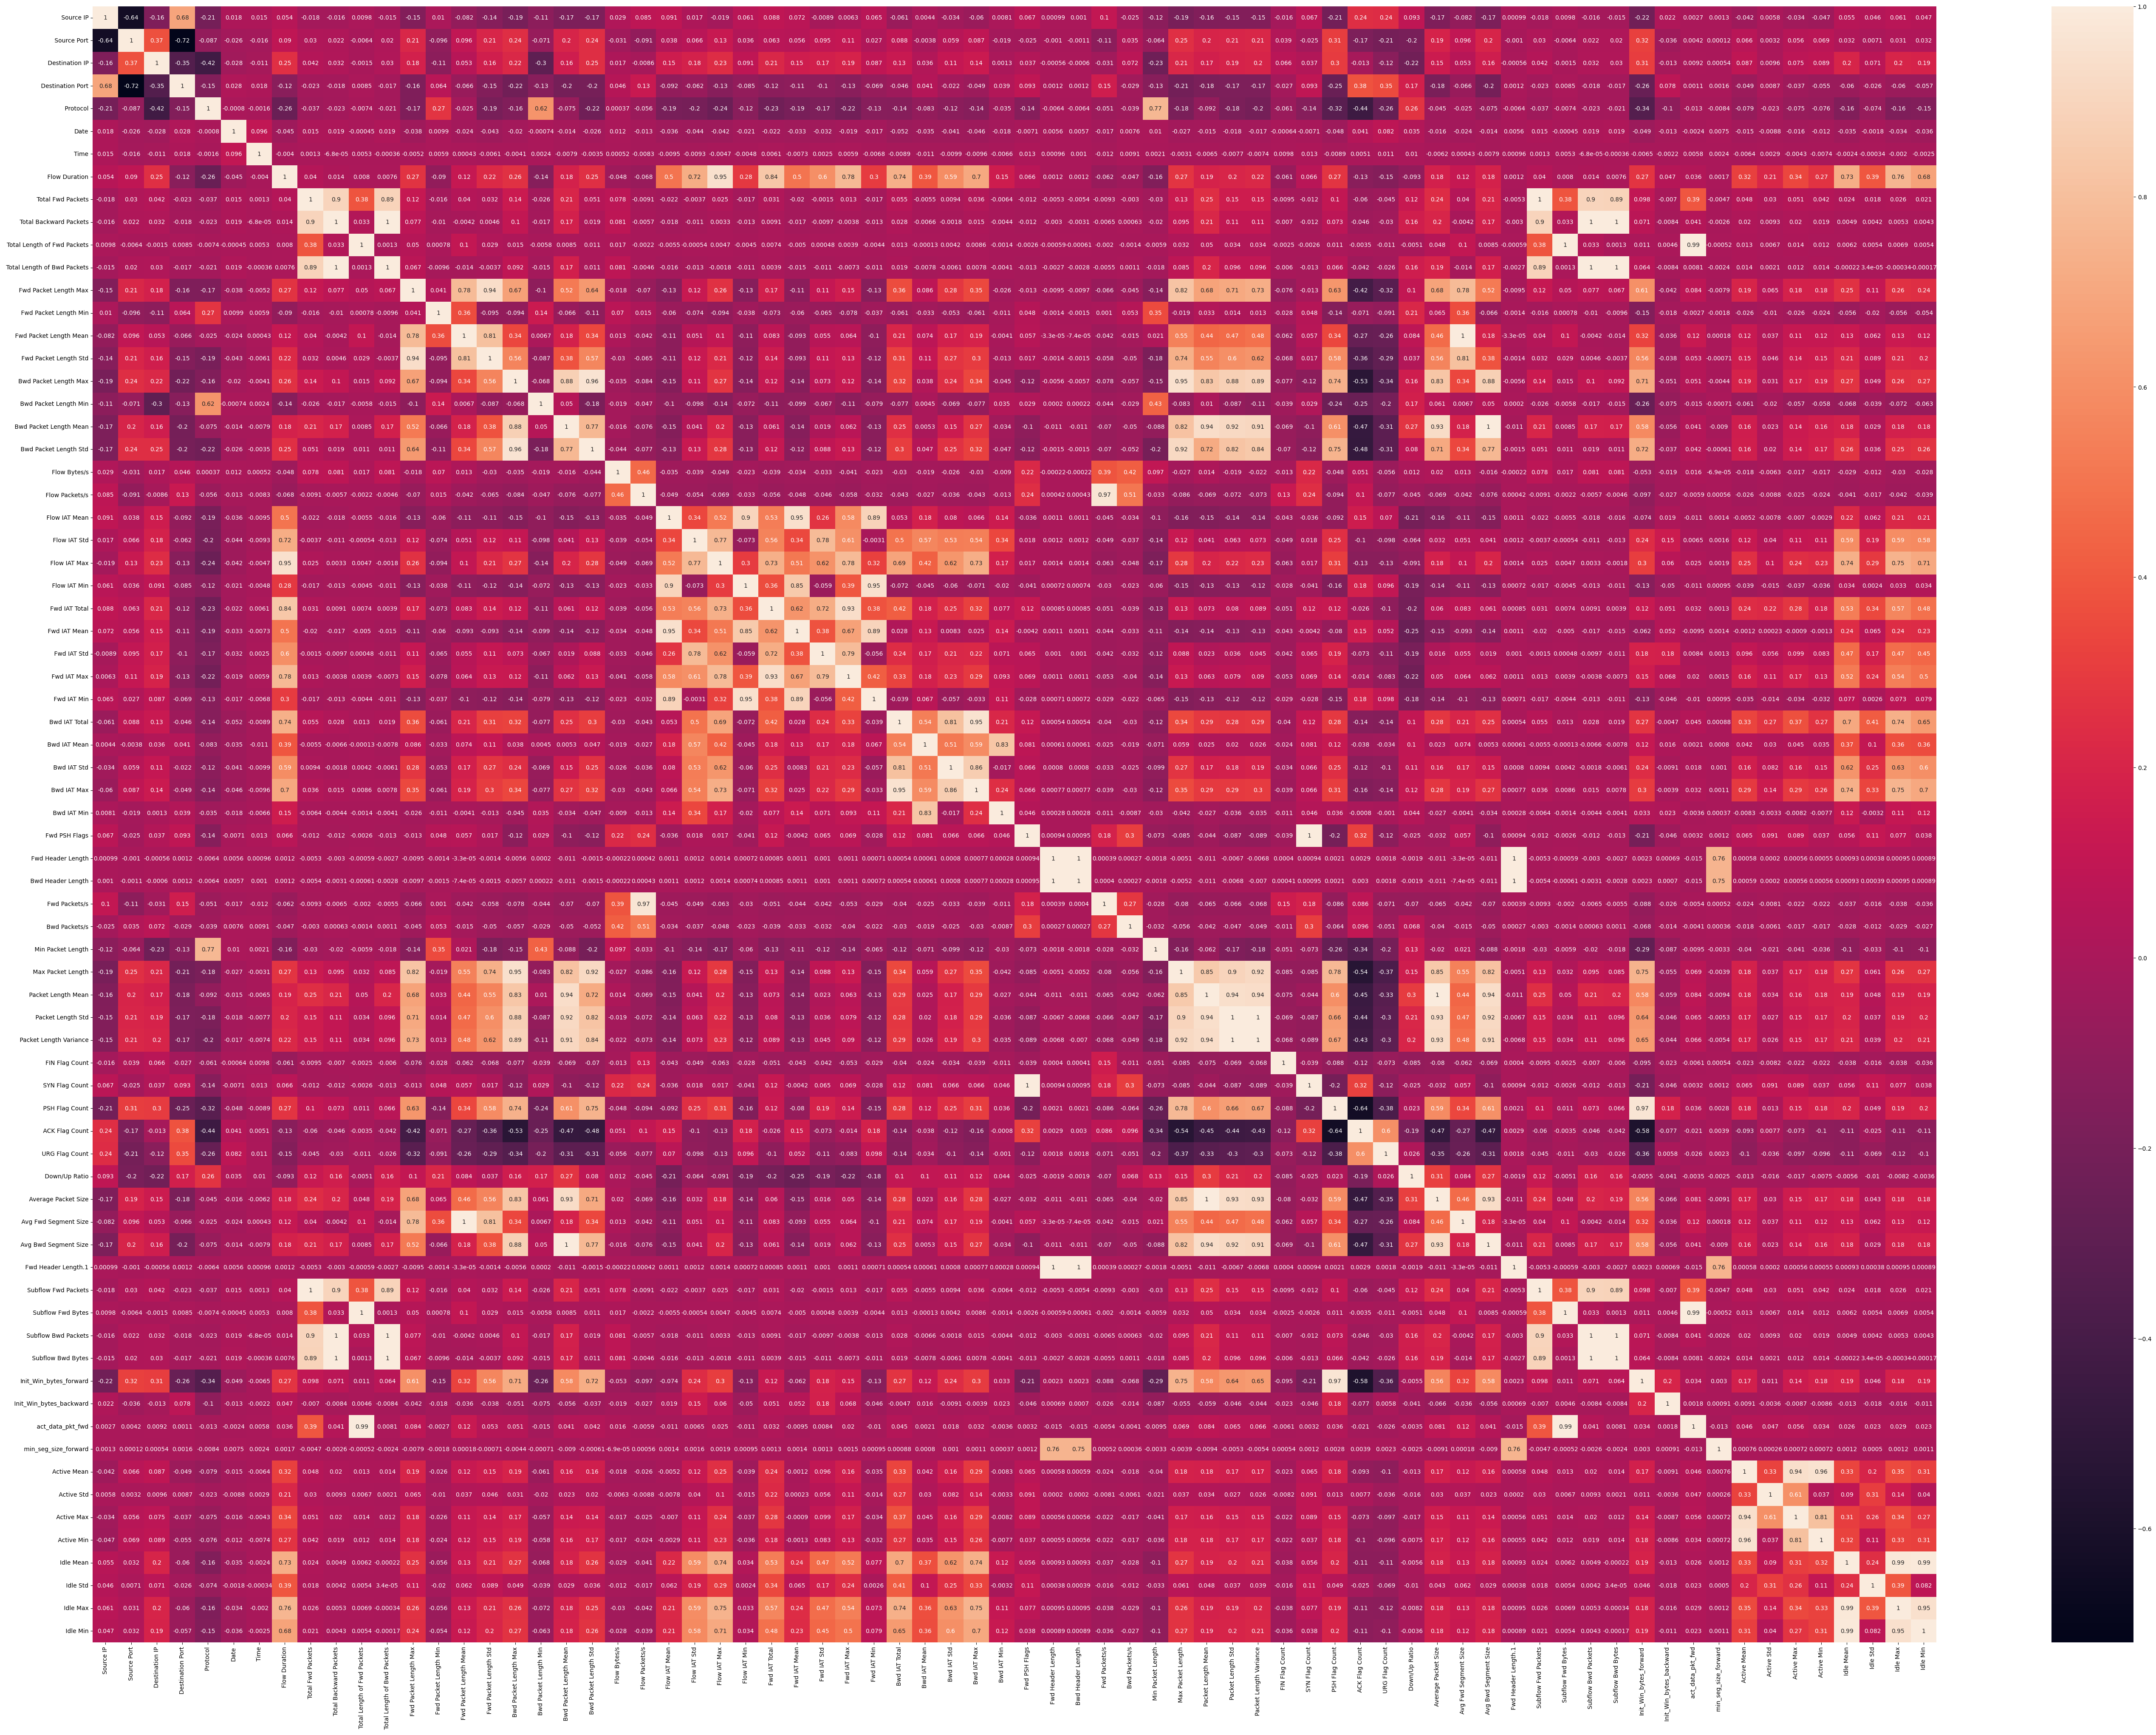

In [24]:
#gaining insights from the heatmap 
plt.figure(figsize=(70,50))
sns.heatmap(X_resampled.corr(),annot=True)
#sns.heatmap(X.corr(),annot=True)

In [25]:
#spliting the dataset as 70% training and 30 testing data

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=42)

In [27]:
#making the traing the Decision tree Classifier

dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)


DecisionTreeClassifier()

In [34]:

print("Decision Tree\n")
print(classification_report(y_pred,y_test))

Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     92776
           1       1.00      1.00      1.00     64302

    accuracy                           1.00    157078
   macro avg       1.00      1.00      1.00    157078
weighted avg       1.00      1.00      1.00    157078



In [33]:
#making the traing the Decision tree Classifier
rf1 = RandomForestClassifier(n_estimators=50,random_state=42)

rf1.fit(X_train,y_train)


accuracy:  99.99681686805282


In [36]:
print("Random forest\n")
print(classification_report(y_predrf,y_test))

Random forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     92781
           1       1.00      1.00      1.00     64297

    accuracy                           1.00    157078
   macro avg       1.00      1.00      1.00    157078
weighted avg       1.00      1.00      1.00    157078

